* Notebook created by nov05 on 2024-12-29
* It was run locally with conda env `sagemaker_py310`.  

---   
* View the S3 bucket in your account   
    https://s3.console.aws.amazon.com/s3/buckets/aft-vbi-pds
* [Docs > Models and pre-trained weights > ResNet > resnet34](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet34.html)  
* GitHub gist [code snippets](https://gist.github.com/nov05/95cb7edcbe2e8bb68c9d29bdc00b9ca8)   

In [8]:
%pwd

'd:\\github\\udacity-nd009t-capstone-starter\\starter'

In [124]:
## windows cmd to launch notepad to edit aws credential file
# !notepad C:\Users\guido\.aws\config
!notepad C:\Users\guido\.aws\credentials

In [125]:
## reset the session after updating credentials
import boto3 # type: ignore
boto3.DEFAULT_SESSION = None
import sagemaker # type: ignore
from sagemaker import get_execution_role # type: ignore

# Extract and print the account ID
sts_client = boto3.client('sts')
response = sts_client.get_caller_identity() 
account_id = response['Account']

role_arn = get_execution_role()  ## get role ARN
if 'AmazonSageMaker-ExecutionRole' not in role_arn:
    ## Go to "IAM - Roles", search for "SageMaker", find the execution role.
    voclabs_role_arn = role_arn
    sagemaker_role_arn = "arn:aws:iam::570668189909:role/service-role/AmazonSageMaker-ExecutionRole-20250126T194519"
session = sagemaker.Session()  ## "default"
region = session.boto_region_name
bucket = session.default_bucket()

print(f"Current AWS Account ID: {account_id}")
print("AWS Region: {}".format(region))
print("Default Bucket: {}".format(bucket))
print(f"Role voclabs ARN: {voclabs_role_arn}") ## If local, Role ARN: arn:aws:iam::807711953667:role/voclabs
print("SageMaker Role ARN: {}".format(sagemaker_role_arn)) 

## generate secrets.env. remember to add it to .gitignore  
import wandb
wandb.sagemaker_auth(path="../secrets") 

## get my own AWS account number
with open('../secrets/aws_account_number', 'r') as file:
    for line in file:
        aws_account_number = line.strip()
        break

[02/04/25 13:29:17] INFO     Found credentials in shared credentials file: ~/.aws/credentials   ]8;id=582660;file://d:\Users\guido\miniconda3\envs\sagemaker_py310\lib\site-packages\botocore\credentials.py\credentials.py]8;;\:]8;id=188325;file://d:\Users\guido\miniconda3\envs\sagemaker_py310\lib\site-packages\botocore\credentials.py#1278\1278]8;;\

[02/04/25 13:29:22] WARNING  Couldn't call 'get_role' to get Role ARN from role name voclabs to get ]8;id=993436;file://d:\Users\guido\miniconda3\envs\sagemaker_py310\lib\site-packages\sagemaker\session.py\session.py]8;;\:]8;id=466925;file://d:\Users\guido\miniconda3\envs\sagemaker_py310\lib\site-packages\sagemaker\session.py#5971\5971]8;;\
                             Role path.                                                                            

Current AWS Account ID: 570668189909
AWS Region: us-east-1
Default Bucket: sagemaker-us-east-1-570668189909
Role voclabs ARN: arn:aws:iam::570668189909:role/voclabs
SageMaker Role ARN: arn:aws:iam::570668189909:role/service-role/AmazonSageMaker-ExecutionRole-20250126T194519


## 👉 **Data Preparation**
**TODO:** Run the cell below to download the data.

The cell below creates a folder called `data`, downloads training data and arranges it in subfolders. Each of these subfolders contain images where the number of objects is equal to the name of the folder. For instance, all images in folder `1` has images with 1 object in them. Images are not divided into training, testing or validation sets. If you feel like the number of samples are not enough, you can always download more data (instructions for that can be found [here](https://registry.opendata.aws/amazon-bin-imagery/)). However, we are not assessing you on the accuracy of your final trained model, but how you create your machine learning engineering pipeline.

* View the S3 bucket in your account   
    https://s3.console.aws.amazon.com/s3/buckets/aft-vbi-pds
    

In [26]:
## example code to download a file from s3 bucket
import boto3
from botocore import UNSIGNED
from botocore.client import Config
# Create an S3 client with unsigned requests (public access)
s3_client = boto3.client('s3', config=Config(signature_version=UNSIGNED))
s3_client.download_file(
    Bucket='aft-vbi-pds',
    Key='bin-images/100313.jpg',
    Filename='../data/bin-images/100313.jpg'
)

In [25]:
import os
import json
from tqdm import tqdm
import boto3
from botocore import UNSIGNED
from botocore.client import Config

def download_and_arrange_data(
        prefix='bin-images', 
        file_extension='.jpg',
        download_dir='../data/bin-images',
        partition=True):
    
    s3_client = boto3.client('s3', config=Config(signature_version=UNSIGNED))  ## public access

    ## There are 140536 image file names in the list. 
    with open('file_list.json', 'r') as f:
        d = json.load(f)

    for k, v in d.items():  ## There are 5 items (for 5 classes) in the JSON file.
        print(f"Downloading images/metadata of images with {k} object...")
        if partition:
            download_dir = os.path.join(download_dir, k)
        if not os.path.exists(download_dir):
            os.makedirs(download_dir)
        for file_path in tqdm(v):
            file_name = os.path.basename(file_path).split('.')[0] + file_extension
            s3_client.download_file(
                'aft-vbi-pds', 
                prefix+'/'+file_name,  ## e.g. metadata/100313.json
                download_dir+'/'+file_name)
            
## download metadata, 17.9 MB, 56m 57.4s
download_and_arrange_data(
    prefix='metadata', 
    file_extension='.json',
    download_dir='../data/metadata',
    partition=False)

100%|██████████| 1228/1228 [06:36<00:00,  3.09it/s]


100%|██████████| 2299/2299 [12:38<00:00,  3.03it/s]


100%|██████████| 2666/2666 [14:35<00:00,  3.04it/s]


100%|██████████| 2373/2373 [12:54<00:00,  3.06it/s]


100%|██████████| 1875/1875 [10:11<00:00,  3.07it/s]


In [1]:
print("total metadata file number:", 1228 + 2299 + 2666 + 2373 + 1875)

total metadata file number: 10441


In [ ]:
## example code to get jpg-json file name pairs 
import json
import random
def get_file_list(s3_uri):
    s3_client = boto3.client('s3')
    bucket, key = s3_uri.replace("s3://", "").split("/", 1)
    response = s3_client.get_object(Bucket=bucket, Key=key)
    json_content = json.loads(response["Body"].read().decode("utf-8"))
    file_list = []
    for label, file_name_list in json_content.items():
        for file_name in file_name_list:
            file_list.append((file_name.split("/")[-1].split(".")[0], label))
    random.shuffle(file_list)
    return file_list  
FILE_LIST_KEY = "s3://p5-amazon-bin-images/file_list.json"
file_list = get_file_list(FILE_LIST_KEY)
print("total image file number:", len(file_list))
print("Example file list:", file_list[:5])

[01/31/25 05:43:31] INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=399315;file://d:\Users\guido\miniconda3\envs\sagemaker_py310\lib\site-packages\botocore\httpchecksum.py\httpchecksum.py]8;;\:]8;id=725570;file://d:\Users\guido\miniconda3\envs\sagemaker_py310\lib\site-packages\botocore\httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

total image file number: 10441
Example file list: [('03146', '4'), ('102813', '4'), ('100517', '5'), ('08340', '4'), ('06487', '2')]


In [113]:
## example code for webdataset
import webdataset as wds
import io
import json
print("👉 WebDataset version:", wds.__version__)
tar_stream = io.BytesIO()
base_name = "100313"
with wds.TarWriter(tar_stream) as sink:
    with open("../data/bin-images/100313.jpg", "rb") as f:
        image_data = f.read()
    with open("../data/metadata/100313.json", "rb") as f:
        label = json.load(f)['EXPECTED_QUANTITY']  ## load json binary
    with open("../data/metadata/100313.json", "rb") as f:
        metadata_data = f.read()
    # Save as WebDataset sample
    sink.write({
        "__key__": f"{base_name}",
        "image": image_data,
        "label": str(label),
        "metadata": metadata_data,
    })
# Once the tar file is in memory, save to local file
tar_stream.seek(0)
with open("../data/test/test.tar", "wb") as f:
    f.write(tar_stream.getvalue())
!tar -tf ../data/test/test.tar

👉 WebDataset version: 0.2.100
100313.image
100313.label
100313.metadata


<class 'int'> 1
<class 'str'> {
    "BIN_FCSKU_DATA": {
        "B00O0WRO08": {

<class 'PIL.JpegImagePlugin.JpegImageFile'>


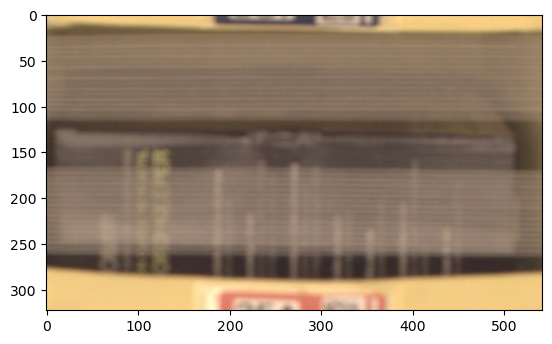

In [121]:
## example code of WebDataset. A WebDataset is an instance of IterableDataset.
## This cell converts .tar to training data formats
## The .tar file contains jpg in binary format and label in string format
import webdataset as wds
import matplotlib.pyplot as plt
from PIL import Image
import io
train_dataset = (
    wds.WebDataset("../data/test/test.tar", shardshuffle=False)
        ## names have to be the same with the WebDataset keys
        .to_tuple("image", "label", "metadata")  
        .map_tuple(
            lambda x:x, 
            lambda x:int(x.decode()), 
            lambda x:x.decode(),
        )
)
for image,label,metadata in iter(train_dataset):
    print(type(label), label)
    print(type(metadata), metadata[:50])
    img = Image.open(io.BytesIO(image))
    print(type(img))
    plt.imshow(img)
    plt.show()

<class 'str'> 3
<class 'PIL.JpegImagePlugin.JpegImageFile'>


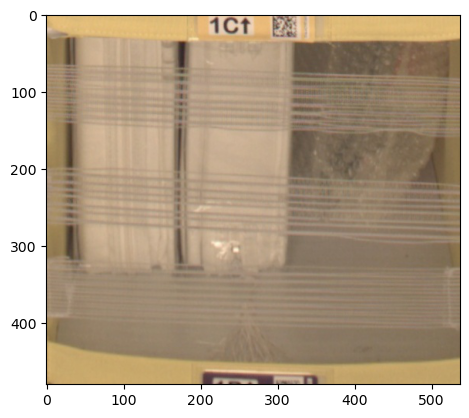

Exception ignored in: <function Pipe.__del__ at 0x0000020C9C1BD900>
Traceback (most recent call last):
  File "d:\Users\guido\miniconda3\envs\sagemaker_py310\lib\site-packages\webdataset\gopen.py", line 121, in __del__
    self.close()
  File "d:\Users\guido\miniconda3\envs\sagemaker_py310\lib\site-packages\webdataset\gopen.py", line 109, in close
    self.wait_for_child()
  File "d:\Users\guido\miniconda3\envs\sagemaker_py310\lib\site-packages\webdataset\gopen.py", line 83, in wait_for_child
    raise IOError(f"{self.args}: exit {self.status} (read) {info}")
OSError: (('aws s3 cp s3://p5-amazon-bin-images/webdataset/train/train-shard-000001.tar -',), {'shell': True, 'bufsize': 8192}): exit 1 (read) {}


In [139]:
## test code streaming data from s3. pay attention to the object types.
import webdataset as wds
import matplotlib.pyplot as plt
from PIL import Image
import io
try:
    s3_uri = "s3://p5-amazon-bin-images/webdataset/train/train-shard-{000000..000001}.tar"
    path = f"pipe:aws s3 cp {s3_uri} -"  ## write to standard output (stdout)
    train_dataset = (
        wds.WebDataset(
                path, 
                shardshuffle=True,
                # nodesplitter=wds.split_by_worker,  ## distributed training
            )
            .shuffle(1000)  # Shuffle dataset 
            ## The tuple names have to be the same with the WebDataset keys
            ## check the "scripts_process/*convert_to_webdataset*.py" files
            .to_tuple("image", "label")  ## Tuple of image and label
            .map_tuple(
                lambda x:Image.open(io.BytesIO(x)),  # Apply the train transforms to the image
                lambda x:x.decode(),
            )  
    ) 
    for image,label in iter(train_dataset):
        print(type(label), label)
        # img = Image.open(io.BytesIO(image))
        print(type(image))
        plt.imshow(image)
        plt.show()
        break
except Exception as e:
    print(e)

# 👉 **Convert data to WebDataset and upload to AWS S3**

* [ScriptProcessor](https://sagemaker.readthedocs.io/en/stable/api/training/processing.html#sagemaker.processing.ScriptProcessor) official documentation    
* [My tutorial](https://docs.google.com/document/d/17KzWVf84xQJVNH1jd6yh_FLgr781QcdKng1JIF6P5X4): Create custom docker image for SageMaker data processing jobs, create AWS ECR private repo, and upload the image to the repo   
* [AWS re:Post](https://repost.aws/en/knowledge-center/secondary-account-access-ecr), pull ECR image from the repo of another account  

In [4]:
'''
There is no need to run this cell. Just update permissions of the ECR repo 
to allow pulling from another AWS account, and add the "AmazonEC2ContainerRegistryPowerUser"
policy permissions to the SageMaker role of this account.
'''
# ## To pull ECR image from another AWS account 
# import boto3
# import subprocess
# import base64
# ecr_client = boto3.client('ecr', region_name='us-east-1')
# # Retrieve the authentication token from ECR
# response = ecr_client.get_authorization_token()
# authorization_data = response['authorizationData'][0]
# token = authorization_data['authorizationToken']
# registry_uri = authorization_data['proxyEndpoint']
# decoded_token = base64.b64decode(token).decode('utf-8')
# username, password = decoded_token.split(':')
# # Docker login command
# login_command = f"docker login --username {username} --password {password} {registry_uri}"
# subprocess.run(login_command, shell=True, check=True)
# # Now you can use this image in your SageMaker processing job

CompletedProcess(args='docker login --username AWS --password eyJwYXlsb2FkIjoiNExSVy96aU9CYmk0NUQ5UU5wa1I0MmNMY3orakMzaTVyTVlLYVBidTRWZmt5R1dTdlNDa24rbFRMSUJvbEhiVjVWQWZCemhpYUVIa3JYU2R2QTlIeis0M0pFTThuZXk3Mi9oTU1TMzl2cmg2am5EZDhXSWVDZGpDdVRNQmZDcFRBMDBDd1ZabDB2QlZhRWVZcmpSTzJzQnUvM2JZQW5jcVo2dGVSdURLZWIwM1ZnQWV2R3FFajlwVjFDQUhQM3E0NWxNMHN2NmRoQ21sVUVWTmZteGNmUzFDbHI0ZUx3VDhCbFBvYzFvcDFOZHdRV2c2NVhXUFFWWFM3S0srSWM3SHpDemJjQUdsL0JkdGQ1MzhqUlNrRURWZkh4bGVmekc2eTNJVDkvYkpnd2Fqa0RJY1JKcTB6OXRSV0FEc25uejVSZW1EanRQVzk2M2gxVzB6NnNvTUx2b1Q5bzRRd1FycXBkbkhZKzgxNVVOcU8wY0N6Sk5sL2JlNjEzZGpGQXM3cXRDd2J5S0pBc2hNa3E3dURVdUdwakNURWtISTM1dWkzVEI2dWdsNk41c2JPTXQ5bDZjUFJZU0MzcTJETmt1MHh6R0xNa0liQ1g5YlYwblh5WDU1YlF1MW82RDN5L2hCbDMzTjVDblR4TFhNWWdOdFQvSi9vMXUzMER1bWc5ck9vQWRvNEJqOGJKYTFaYk50ZU9DV0RQYU5YcDVVZVhHZG03Q0MvTVVZNnZwNWtWWE1UYUNLUmI2ZnppSG5HdEoxVmZOeVg1aTBhaDVmSEZDOHRkRks5U1VyVzlrSFZaL3Q4V2lnaDlKYTR6TUlHSGdQaURJVithU1cwdm5lenplK3JESXJJL25PbkE2OHQ2QWVxb1NkalpDZEptMGNubnI5R0JrL3ZWcVBtUmlpcVZJUG5pTl

### Test

In [ ]:
## example code for webdataset.TarWrite() conversion
## this cell reads the first 20 jpg-json pairs and write them to 2 tar files
from sagemaker.processing import ScriptProcessor
processor = ScriptProcessor(
    command=['python3'],
    ## You can use a custom image or use the default SageMaker image
    ## You can pull from AWS ECR or DockerHub
    image_uri=f'{aws_account_number}.dkr.ecr.us-east-1.amazonaws.com/udacity/p5-amazon-bin-images:latest', 
    role=sagemaker_role_arn,  # Execution role
    instance_count=1,
    instance_type='ml.t3.large',  # Use the appropriate instance type
    volume_size_in_gb=10,  # Minimal disk space since we're streaming
    base_job_name='p5-amazon-bin-images' 
)
processor.run(
    ## ⚠️ I made a terrible mistake here by naming the script as "webdataset.py" 
    ## which is the same as the package name. You know what happened next.
    code='../scripts_process/test_convert_to_webdataset.py',  # Your script to process data
    arguments=[
        '--SM_INPUT_BUCKET', 'aft-vbi-pds',
        '--SM_INPUT_PREFIX_IMAGES', 'bin-images/',
        '--SM_INPUT_PREFIX_METADATA', 'metadata/',
        '--SM_OUTPUT_BUCKET', 'p5-amazon-bin-images',
        '--SM_OUTPUT_PREFIX', 'webdataset/',
    ]
)

[01/30/25 20:17:20] INFO     Creating processing-job with name                                      ]8;id=766417;file://d:\Users\guido\miniconda3\envs\sagemaker_py310\lib\site-packages\sagemaker\session.py\session.py]8;;\:]8;id=536363;file://d:\Users\guido\miniconda3\envs\sagemaker_py310\lib\site-packages\sagemaker\session.py#1575\1575]8;;\
                             p5-amazon-bin-images-2025-01-31-02-17-16-724                                          

.......👉 image_keys: ['bin-images/', 'bin-images/00001.jpg', 'bin-images/00002.jpg', 'bin-images/00003.jpg', 'bin-images/00004.jpg', 'bin-images/00005.jpg', 'bin-images/00006.jpg', 'bin-images/00007.jpg', 'bin-images/00008.jpg', 'bin-images/00009.jpg']
⚠️ Skipping non-image file: bin-images/
🟢 Successfully uploaded tar file to s3://p5-amazon-bin-images/webdataset/data_0.tar
👉 image_keys: ['bin-images/00010.jpg', 'bin-images/00011.jpg', 'bin-images/00012.jpg', 'bin-images/00013.jpg', 'bin-images/00014.jpg', 'bin-images/00015.jpg', 'bin-images/00016.jpg', 'bin-images/00017.jpg', 'bin-images/00018.jpg', 'bin-images/00019.jpg']
🟢 Successfully uploaded tar file to s3://p5-amazon-bin-images/webdataset/data_1.tar



In [ ]:
job_name = processor.latest_job.job_name
processing_job_desc = processor.sagemaker_session.describe_processing_job(job_name)
job_status = processing_job_desc['ProcessingJobStatus']
print(f"Processing job status: {job_status}")

Processing job status: Completed


## Execution

In [ ]:
%%time
## TODO: Perform any data cleaning or data preprocessing
## This cell shuffle then split the 10K dataset to train, val, and test.  
## And convert the datasets to WebDataset tar files for SageMaker FastFile input mode.
from sagemaker.processing import ScriptProcessor
processor = ScriptProcessor(
    command=['python3'],
    ## You can use a custom image or use the default SageMaker image
    ## You can pull from AWS ECR or DockerHub
    image_uri=f'{aws_account_number}.dkr.ecr.us-east-1.amazonaws.com/udacity/p5-amazon-bin-images:latest', 
    role=sagemaker_role_arn,  # Execution role
    instance_count=1,
    instance_type='ml.t3.large',  # Use the appropriate instance type
    volume_size_in_gb=10,  # Minimal disk space since we're streaming
    base_job_name='p5-amazon-bin-images' 
)
processor.run(
    code='../scripts_process/convert_to_webdataset_10k.py',  # process the 10K files in the list
    arguments=[
        '--SM_INPUT_BUCKET', 'aft-vbi-pds',
        '--SM_INPUT_PREFIX_IMAGES', 'bin-images/',
        '--SM_INPUT_PREFIX_METADATA', 'metadata/',
        '--SM_OUTPUT_BUCKET', 'p5-amazon-bin-images',
        '--SM_OUTPUT_PREFIX', 'webdataset/',
    ]
)
## It took about 13 minutes to process 10.4K files (1.2 GB). If we keep 1K files per shard, 
## processing 500K files could take around 11 hours. I’ll probably increase it to 10K 
## files per shard, which would make each tar file around 1 GB and speed up the process.
## CPU times: total: 21.9 s
## Wall time: 12min 58s

[01/31/25 17:55:50] INFO     Creating processing-job with name                                      ]8;id=28680;file://d:\Users\guido\miniconda3\envs\sagemaker_py310\lib\site-packages\sagemaker\session.py\session.py]8;;\:]8;id=800486;file://d:\Users\guido\miniconda3\envs\sagemaker_py310\lib\site-packages\sagemaker\session.py#1575\1575]8;;\
                             p5-amazon-bin-images-2025-01-31-23-55-46-542                                          

........................................................................Starting data processing...
🟢 File list successfully loaded from s3://p5-amazon-bin-images/file_list.json
    Total number of image files: 10441
# writing train-shard-000000.tar 0 0.0 GB 0
# writing train-shard-000001.tar 1000 0.1 GB 1000
# writing train-shard-000002.tar 1000 0.1 GB 2000
# writing train-shard-000003.tar 1000 0.1 GB 3000
# writing train-shard-000004.tar 1000 0.1 GB 4000
# writing train-shard-000005.tar 1000 0.1 GB 5000
# writing train-shard-000006.tar 1000 0.1 GB 6000
# writing train-shard-000007.tar 1000 0.1 GB 7000
🟢 Successfully uploaded shard files to s3://p5-amazon-bin-images/webdataset/train/:
    ['train-shard-000000.tar', 'train-shard-000001.tar', 'train-shard-000002.tar', 'train-shard-000003.tar', 'train-shard-000004.tar', 'train-shard-000005.tar', 'train-shard-000006.tar', 'train-shard-000007.tar']
# writing val-shard-000000.tar 0 0.0 GB 0
# writing val-shard-000001.tar 1000 0.1 GB 1000
🟢 

'\nIt took about 13 minutes to process 10.4K files (1.2 GB). If we keep 1K files per shard, \nprocessing 500K files could take around 11 hours. I’ll probably increase it to 10K \nfiles per shard, which would make each tar file around 1 GB and speed up the process.\n'

## 👉 **Dataset**  

**TODO:** Explain what dataset you are using for this project. Give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understanding of it. You can find more information about the data [here](https://registry.opendata.aws/amazon-bin-imagery/).  

In [142]:
from sagemaker.pytorch import PyTorch
from sagemaker.inputs import TrainingInput
data_base_path = "s3://p5-amazon-bin-images/webdataset/"
# train_data = TrainingInput(data_base_path + "train/", 
#                            content_type="application/x-tar")
# val_data = TrainingInput(data_base_path + "val/", 
#                          content_type="application/x-tar")
# test_data = TrainingInput(data_base_path + "test/", 
#                           content_type="application/x-tar")
train_data_path = data_base_path + "train/train-shard-{000000..000001}.tar"
val_data_path = data_base_path + "val/val-shard-{000000..000000}.tar"
test_data_path = data_base_path + "test/test-shard-{000000..000000}.tar"
print(train_data_path)
## ⚠️ don't use prefix in output_path, cause source folder will be created 
## at bucket level, while other folders, e.g. debug-output, at prefix levle.
output_path = "s3://p5-amazon-bin-images-train/"  

s3://p5-amazon-bin-images/webdataset/train/train-shard-{000000..000001}.tar


## 👉 **Model Training (Distributed Data Parallel)**  

**TODO:** This is the part where you can train a model. The type or architecture of the model you use is not important.   
**Note:** You will need to use the `train.py` script to train your model.

* Official document: [SageMaker distributed data parallel (SDP) with PyTorch](https://sagemaker-examples.readthedocs.io/en/latest/training/distributed_training/index.html#pytorch-distributed)   

In [156]:
#TODO: Declare your model training hyperparameter.
#NOTE: You do not need to do hyperparameter tuning. You can use fixed hyperparameter values
import json
from sagemaker.debugger import (
    Rule,
    ## debugger
    DebuggerHookConfig,
    rule_configs,
    ## profiler 
    ProfilerRule,
    ProfilerConfig,
    FrameworkProfile
)
## SageMaker will automatically append these as command-line arguments  
hyperparameters = {
    'epochs': 20,   
    'batch-size': 256,   
    'opt-learning-rate': 8e-5,  
    'opt-weight-decay': 1e-5,  
    'lr-sched-step-size': 5,  
    'lr-sched-gamma': 0.5,
    'early-stopping-patience': 5,
    'model-type': 'resnet50', 
    'wandb': True,  
    'debug': False, 
## input data 
    "train-data-path": train_data_path,
    "val-data-path": val_data_path,
    "test-data-path": test_data_path,
    "train-dataset-size": 2000,  # Torch DDP sampler argument
    "class-weights-dict": {
        1: 1.7004885993485341, 
        2: 0.9083079599826012, 
        3: 0.7832708177044261, 
        4: 0.8799831436999579, 
        5: 1.1137066666666666
    },
}
rules = [
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]
hook_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "100", 
        "eval.save_interval": "10"
    }
)
profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, 
    framework_profile_params=FrameworkProfile(num_steps=10)
)

[02/04/25 18:25:06] WARNING  Framework profiling will be deprecated from tensorflow 2.12 and     ]8;id=576857;file://d:\Users\guido\miniconda3\envs\sagemaker_py310\lib\site-packages\sagemaker\deprecations.py\deprecations.py]8;;\:]8;id=272227;file://d:\Users\guido\miniconda3\envs\sagemaker_py310\lib\site-packages\sagemaker\deprecations.py#34\34]8;;\
                             pytorch 2.0 in sagemaker>=2.                                                          
                             See: https://sagemaker.readthedocs.io/en/stable/v2.html for                           
                             details.                                                                              

* Check [SageMaker AI Pricing](https://aws.amazon.com/sagemaker-ai/pricing/) > On-Demand Pricing > Training  
    | Instance Type      | vCPU | Memory  | Price per Hour |
    |--------------------|------|---------|----------------|
    | ml.g4dn.xlarge      | 4    | 16 GiB  | $0.736         |
    |ml.p3.2xlarge	| 8	| 61 GiB	| $3.825 |

<br>  

* Documentation > Amazon SageMaker > Developer Guide   
  [**Use the PyTorch framework estimators in the SageMaker Python SDK**](https://docs.aws.amazon.com/sagemaker/latest/dg/data-parallel-framework-estimator.html)    

* sagemaker 2.239.0  
  [**PyTorch Guide to SageMaker’s distributed data parallel library**](https://sagemaker.readthedocs.io/en/stable/api/training/sdp_versions/v1.0.0/smd_data_parallel_pytorch.html)  



In [163]:
#TODO: Create your training estimator
estimator = PyTorch(
    entry_point='train.py',  # Your training script that defines the ResNet50 model and training loop
    source_dir='../scripts_train',  # Directory where your script and dependencies are stored
    role=sagemaker_role_arn,
    framework_version='1.13.1',  # Use the PyTorch version you need
    py_version='py39',
    instance_count=2,  ## multi-instance training, Udacity account level limit 2
    # instance_type='ml.p3.2xlarge',  ## 16GB, Use GPU instances for deep learning
    instance_type='ml.g4dn.xlarge',  ## 16GB, 1 GPU per instance
    output_path=output_path,  ## if not specify, output to the sagemaker default bucket
    hyperparameters=hyperparameters,
    # use_spot_instances=True,
## Debugger and profiler parameters
    # rules=rules,
    # debugger_hook_config=hook_config,    
    # profiler_config=profiler_config,
## Training using SMDataParallel Distributed Training Framework
    # distribution={"pytorchddp": {"enabled": True}}  # mpirun, activates SMDDP AllReduce OR AllGather
    # distribution={"torch_distributed": {"enabled": True}}  # torchrun, activates SMDDP AllGather
    distribution={"smdistributed": {"dataparallel": { "enabled": True}}},  # mpirun, activates SMDDP AllReduce OR AllGather
) 

In [164]:
%%time
# TODO: Fit your estimator
from datetime import datetime
estimator.fit(
    wait=True,  
    job_name=f"p5-amazon-bin-job-{datetime.now().strftime('%Y%m%d-%H%M%S')}", 
    ## Use WebDataset pipe to stream data instead 
    # inputs={
    #     "train": train_data,  
    #     "validation": val_data, 
    #     "test": test_data,
    # },  
)

[02/04/25 20:46:16] INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=168965;file://d:\Users\guido\miniconda3\envs\sagemaker_py310\lib\site-packages\sagemaker\telemetry\telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=961842;file://d:\Users\guido\miniconda3\envs\sagemaker_py310\lib\site-packages\sagemaker\telemetry\telemetry_logging.py#90\90]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

[02/04/25 20:46:18] INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=683949;file://d:\Users\guido\miniconda3\envs\sagemaker_py310\lib\site-packages\sagemaker\image_uris.py\image_uris.py]8;;\:]8;id=436651;file://d:\Users\guido\miniconda3\envs\sagemaker_py310\lib\site-packages\sagemaker\image_uris.py#679\679]8;;\
                             instance_type, framework etc.                                                         

                    INFO     Creating training-job with name: p5-amazon-bin-job-20250204-204616     ]8;id=800852;file://d:\Users\guido\miniconda3\envs\sagemaker_py310\lib\site-packages\sagemaker\session.py\session.py]8;;\:]8;id=834872;file://d:\Users\guido\miniconda3\envs\sagemaker_py310\lib\site-packages\sagemaker\session.py#1042\1042]8;;\

2025-02-05 02:46:22 Starting - Starting the training job...
2025-02-05 02:46:36 Starting - Preparing the instances for training...
2025-02-05 02:47:30 Downloading - Downloading the training image..................
2025-02-05 02:50:32 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
/opt/conda/lib/python3.9/site-packages/paramiko/pkey.py:100: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
/opt/conda/lib/python3.9/site-packages/paramiko/transport.py:259: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,
2025-02-05 02:50:41,051 sagemaker-training-toolkit INFO     I

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ d:\Users\guido\miniconda3\envs\sagemaker_py310\lib\site-packages\IPython\core\magics\execution.p │
│ y:1355 in time                                                                                   │
│                                                                                                  │
│   1352 │   │   │   │   # multi-line %%time case                                                  │
│   1353 │   │   │   │   if expr_val is not None:                                                  │
│   1354 │   │   │   │   │   code_2 = self.shell.compile(expr_val, source, 'eval')                 │
│ ❱ 1355 │   │   │   │   │   out = eval(code_2, glob, local_ns)                                    │
│   1356 │   │   │   except:                                                                       │
│   1357 │   │   │   │   self.shell.showtraceback()                                                │
│   1358 │   │   │   │   return                                                                    │
│ in <module>:3                                                                                    │
│                                                                                                  │
│ d:\Users\guido\miniconda3\envs\sagemaker_py310\lib\site-packages\sagemaker\telemetry\telemetry_l │
│ ogging.py:166 in wrapper                                                                         │
│                                                                                                  │
│   163 │   │   │   │   │   caught_ex = e                                                          │
│   164 │   │   │   │   finally:                                                                   │
│   165 │   │   │   │   │   if caught_ex:                                                          │
│ ❱ 166 │   │   │   │   │   │   raise caught_ex                                                    │
│   167 │   │   │   │   │   return response  # pylint: disable=W0150                               │
│   168 │   │   │   else:                                                                          │
│   169 │   │   │   │   logger.debug(                                                              │
│                                                                                                  │
│ d:\Users\guido\miniconda3\envs\sagemaker_py310\lib\site-packages\sagemaker\telemetry\telemetry_l │
│ ogging.py:137 in wrapper                                                                         │
│                                                                                                  │
│   134 │   │   │   │   start_timer = perf_counter()                                               │
│   135 │   │   │   │   try:                                                                       │
│   136 │   │   │   │   │   # Call the original function                                           │
│ ❱ 137 │   │   │   │   │   response = func(*args, **kwargs)                                       │
│   138 │   │   │   │   │   stop_timer = perf_counter()                                            │
│   139 │   │   │   │   │   elapsed = stop_timer - start_timer                                     │
│   140 │   │   │   │   │   extra += f"&x-latency={round(elapsed, 2)}"                             │
│                                                                                                  │
│ d:\Users\guido\miniconda3\envs\sagemaker_py310\lib\site-packages\sagemaker\workflow\pipeline_con │
│ text.py:346 in wrapper                                                                           │
│                                                                                                  │
│   343 │   │   │                                                                                  │
│   344 │   │   │   return _StepArguments(retrieve_caller_nam

## Standout Suggestions
You do not need to perform the tasks below to finish your project. However, you can attempt these tasks to turn your project into a more advanced portfolio piece.

### Hyperparameter Tuning
**TODO:** Here you can perform hyperparameter tuning to increase the performance of your model. You are encouraged to 
- tune as many hyperparameters as you can to get the best performance from your model
- explain why you chose to tune those particular hyperparameters and the ranges.


In [ ]:
#TODO: Create your hyperparameter search space

In [ ]:
#TODO: Create your training estimator

In [ ]:
# TODO: Fit your estimator

In [ ]:
# TODO: Find the best hyperparameters

### Model Profiling and Debugging
**TODO:** Use model debugging and profiling to better monitor and debug your model training job.

In [ ]:
# TODO: Set up debugging and profiling rules and hooks

In [ ]:
# TODO: Create and fit an estimator

In [ ]:
# TODO: Plot a debugging output.

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [ ]:
# TODO: Display the profiler output

### Model Deploying and Querying
**TODO:** Can you deploy your model to an endpoint and then query that endpoint to get a result?

In [ ]:
# TODO: Deploy your model to an endpoint

In [ ]:
# TODO: Run an prediction on the endpoint

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done

### Cheaper Training and Cost Analysis
**TODO:** Can you perform a cost analysis of your system and then use spot instances to lessen your model training cost?

In [ ]:
# TODO: Cost Analysis

In [ ]:
# TODO: Train your model using a spot instance

### Multi-Instance Training
**TODO:** Can you train your model on multiple instances?

In [ ]:
# TODO: Train your model on Multiple Instances